### 0. Imports

In [2]:
# imports
import textstat as ts
import pandas as pd
from helpers import generate_speaker_affiliations, save_pickle, join_quotes_with_speaker_affiliations, read_most_common, create_model_topic_clusterer
from helpers import plot_across_time, plot_length, plot_metrics_scores, expand_contractions, remove_words, preprocess_quote
from tqdm import tqdm
import seaborn as sns
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from bertopic import BERTopic
sns.set

<function seaborn.rcmod.set(*args, **kwargs)>

### 1. Preprocessing
#### Getting politicians dataset
To obtain a dataset of politicians' quotations, we need to enrich the original *Quotebank* dataset with additional information about the speakers' political affiliations. To achieve that, we propose a preprocessing pipeline.

First, load the *Wikidata* table from the `.parquet` file (provided on the *Quotebank*'s Google Drive). Keep the columns containing information interesting for us - speaker's QID and label, and party's QID, discard the others and drop the rows with missing values. Convert that to a `pandas DataFrame` and dump it into a `.pickle` file. 

Then, for each of the years load the initial *Quotebank* data. The initial dataset is represented as a list of `json` objects - process it into a `DataFrame` in a line-by-line manner, only keeping the quotation content and QID, as well as the speaker's QID. Dump the dataframe into a `.pickle` file.

Next, perform an inner join between the two dataframes on the speaker QID - that way you end up with a dataframe containing quotations, along with information about the speaker's political affiliation.

The *Quotebank* dataset is divided into batches based on the quotation date - 6 files are corresponding to years from 2015 until 2020. Therefore we perform the pipeline explained above 6 times, and then merge the results into a single dataframe. We end up with a dataset of around 17m quotations.

In [2]:
# one time operation - generate a pickle file containing speaker's affiliations
PARQUET_PATH = "data/raw/speaker_attributes.parquet"
SPEAKER_AFFILIATIONS_OUT_PATH = "data/binary/speaker_attributes.pickle"

print("Generating speaker affiliations DF...")
if not os.path.exists(SPEAKER_AFFILIATIONS_OUT_PATH):
    generate_speaker_affiliations(PARQUET_PATH, SPEAKER_AFFILIATIONS_OUT_PATH)
print("Done.\n")

# dataset loading - perform for each batch of the data (2015, 2016, ..., 2020)
years = [i for i in range(2015, 2020)]
for year in years:
    DATASET_PATH_JSON_BZ2 = f"data/raw/quotes-{year}.json.bz2"
    DATASET_PATH_PICKLE = f"data/binary/data-{year}.pickle"
    MERGED_OUT_PATH = f"data/binary/data-{year}.pickle"

    print("Generating quotes DF...")
    if not os.path.exists(DATASET_PATH_PICKLE):
        save_pickle(DATASET_PATH_JSON_BZ2, DATASET_PATH_PICKLE)
    print("Done.\n")

    df_quotes = pd.read_pickle(DATASET_PATH_PICKLE)
    df_affiliations = pd.read_pickle(SPEAKER_AFFILIATIONS_OUT_PATH)
    
    print("Generating merged df...")
    if not os.path.exists(MERGED_OUT_PATH):
        join_quotes_with_speaker_affiliations(df_quotes, df_affiliations, MERGED_OUT_PATH)
    print(year, "Done.\n")

Generating speaker affiliations DF...
Done.

Generating quotes DF...
Done.

Generating merged df...
2015 Done.

Generating quotes DF...
Done.

Generating merged df...
2016 Done.

Generating quotes DF...
Done.

Generating merged df...
2017 Done.

Generating quotes DF...
Done.

Generating merged df...
2018 Done.

Generating quotes DF...
Done.

Generating merged df...
2019 Done.



In [3]:
# merge the results for the separate years into a single dataframe,
# and extracting date from the quote_id and saving it into a new column as datetime.
# Save all into a pickle named data.pickle

if not os.path.exists("data/binary/us-politicians.pickle"):
    years = [2015, 2016, 2017, 2018, 2019]
    paths = [f"data/binary/data-{year}.pickle" for year in years]
    dfs = [pd.read_pickle(path) for path in paths]
    merged_df = pd.concat(dfs, ignore_index=True)
    # create an additional datetime column - useful for temporal analysis
    merged_df["Date-Time"] = pd.to_datetime(merged_df['quote_id'].apply(lambda x : datetime.strptime(x[:10], '%Y-%m-%d')))
    merged_df.to_pickle("data/binary/us-politicians.pickle")

#### US Politicians dataset
To obtain a dataset of US Politician quotations, we proceed to:
1. Only keep the quotations where the speaker's party is `29468` (Republican party) or `29552` (Democratic party).
2. Filter out the rows that have `None` as a value in the `Candidacy` column in the Wikidata - the majority of the speakers affiliated with the political parties were not actual politicians - they are often celebrities, sports stars, TV personalities, etc. We believe it is beneficial to only take the actual politicians, as they are more likely to speak about actual political matters and represent their party's ideology.

Performing step 1 reduces the size of the dataset from 17 million rows to around 8 million rows, and step 2 reduces the size further to around 1.6 million.

In [4]:
# additional preprocessing to obtain the US politicans data
US_POLITICIANS = "data/binary/us-politicians.pickle"
data = pd.read_pickle(US_POLITICIANS)
# filter to only keep the american politicians
data = data[data["party"].isin([29468, 29552])]

In [5]:
# maintain only the quotes where the speakers are actually politicians - they were candidates in at least one election
speaker_data = pd.read_parquet(PARQUET_PATH)
candidates = speaker_data[["id", "candidacy"]]
candidates = candidates.dropna()
candidates = candidates.drop(columns=["candidacy"])
candidates["id"] = candidates["id"].apply(lambda x: int(x[1:]))
candidates.head()

,id
0,23
3,207
11,815
15,946
18,1058


In [6]:
# filter to only keep the ones that actually participated in an election (exclude celebrities etc.)
data = pd.merge(left=data, left_on="speaker_id", right_on="id", right=candidates)
data = data.drop(columns=["id"])
print(data.head())

   speaker_id           quote_id  \
0     1282411  2015-06-11-000090   
1     1282411  2015-08-11-090504   
2     1282411  2015-10-27-125840   
3     1282411  2015-01-19-008025   
4     1282411  2015-12-09-094134   

                                           quotation    speaker  party  \
0  25-year cost estimate for the U.S. nuclear mod...  Ed Markey  29552   
1  The state is transitioning to a higher percent...  Ed Markey  29552   
2  This highly coveted TIGER grant funding would ...  Ed Markey  29552   
3  carefully cutting the Gordian knot that has ti...  Ed Markey  29552   
4  The amendments would improve the safety of agi...  Ed Markey  29552   

   Date-Time  
0 2015-06-11  
1 2015-08-11  
2 2015-10-27  
3 2015-01-19  
4 2015-12-09  


In [8]:
# save to pickle
if not os.path.exists("data/binary/us-politicians.pickle"):
    data.to_pickle("data/binary/us-politicians.pickle")

#### 2. Exploratory Analysis
Here we conduct an initial analysis on the quotes, exploring the distributions of various aspects of the dataset. We load the data and  create the following new columns:
- Flesch reading ease: in the Flesch reading-ease test, higher scores indicate material that is easier to read;
lower numbers mark passages that are more difficult to read.
- Dale Chall readability score: different from other tests, since it uses a lookup table of the most commonly used 3000 English words.
It returns the grade level necessary to understand the sentence. Hence, the higher the score, the higher is the difficulty.
- Text Standard: based upon a combination of all the library's tests, returns the estimated school grade level required to understand the text.
- Reading time: returns the reading time of the given text. Assumes 14.69ms per character.

In [3]:
#load pickle
PICKLE_PATH = "data/binary/us-politicians.pickle"
data = pd.read_pickle(PICKLE_PATH)
data.head()
if not os.path.exists("data/binary/us-politicians-complexity.pickle"):
    data['flesch_reading_ease']=data['quotation'].apply(lambda x : ts.flesch_reading_ease(x))
    data['dale_chall_readability_score']=data['quotation'].apply(lambda x : ts.dale_chall_readability_score_v2(x))
    data['text_standard']=data['quotation'].apply(lambda x : ts.text_standard(x,True))
    data['reading_time']=data['quotation'].apply(lambda x : ts.reading_time(x))
    # save to pickle
    data.to_pickle("data/binary/us-politicians-complexity.pickle")
else:
    PICKLE_PATH = "data/binary/us-politicians-complexity.pickle"
    df = pd.read_pickle(PICKLE_PATH)
data.head()

,speaker_id,quote_id,quotation,speaker,party,Date-Time
0,1282411,2015-06-11-000090,25-year cost estimate for the U.S. nuclear mod...,Ed Markey,29552,2015-06-11
1,1282411,2015-08-11-090504,The state is transitioning to a higher percent...,Ed Markey,29552,2015-08-11
2,1282411,2015-10-27-125840,This highly coveted TIGER grant funding would ...,Ed Markey,29552,2015-10-27
3,1282411,2015-01-19-008025,carefully cutting the Gordian knot that has ti...,Ed Markey,29552,2015-01-19
4,1282411,2015-12-09-094134,The amendments would improve the safety of agi...,Ed Markey,29552,2015-12-09


We then split the DataFrame into two, one for Democrats and one for Republicans.  We take a random sample of Republicans
quotes, since they are significantly more  than Democrats' quotes, in order to have the same amount of sentences analyzed.
This way the representations are clearer but the result doesn't change.
Initially we plot the difference between the length of quotes, then we plot the difference of metrics' score
across all speakers and, subsequently, across all quotes from the two most popular ones: Donald Trump and Barack Obama.
Finally, we see if there are any variations over the years.

In [4]:
# To have a clearer visualization we take into consideration the same amount of quotations from both parties
democrats = data[data["party"] == 29552]
republicans = data[data["party"] == 29468].sample( democrats['quote_id'].count())

Let's examine if the number of quotes from the two parties is balanced across time. To do so, let's plot the distribution of the number of quotes per party across time:

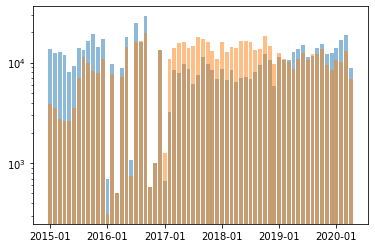

In [11]:
plot_across_time(democrats[["Date-Time","quote_id"]].rename(columns={'quote_id':'count'}), republicans[["Date-Time","quote_id"]].rename(columns={'quote_id':'count'}))

We can see that, despite a few low values in 2016, the distribution is rather regular, and the difference between the number of quotes of democrats and republicans across the year is not substantial enough to hinder our future analysis. Now let's analyse the difference in the distribution of quotes' length of the two parties:

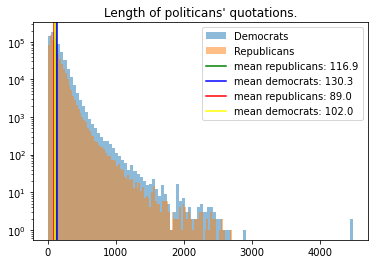

In [12]:
plot_length(democrats, republicans)

We see that the number of quotes decreases uniformly as their lenght increases, with a few outliers over the length 3000. Let's try removing them.

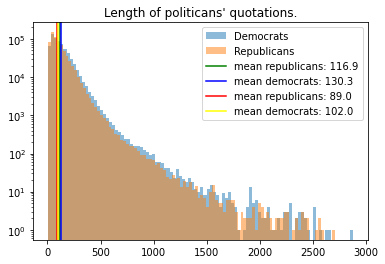

In [13]:
plot_length(democrats[democrats["quotation"].str.len()<3000], republicans[republicans["quotation"].str.len()<3000])

### 2. Topic clustering

In this section we'll try to divide the quotes into clusters of different topics. First, let's see which are the most common words used by politicians.

In [5]:
sample = data.sample(n=int(1e5))
quotes = sample['quotation']
# expand contractions
quotes = quotes.apply(lambda quote: expand_contractions(quote))

# load the stopwords (extend the standard list by the contraction leftovers) and remove them from the quotes 
stopWords = stopwords.words('english') + ['nt', 'ca', 'wo']
quotes = quotes.apply(lambda quote: remove_words(quote, stopWords))

# apply other preprocessing
quotes = quotes.apply(lambda quote: preprocess_quote(quote))

# look at most common words
tokenized = quotes.apply(lambda quote: word_tokenize(quote))
words = tokenized.explode()
words = words.astype("str")
print(words.value_counts()[:10])

people       11513
going         8721
would         7665
think         7204
president     6016
know          5996
us            5533
get           5443
like          5411
one           5148
Name: quotation, dtype: int64


As you can see above, the most common words are somewhat meaningless for understanding the topics that politicians talk about. They are just words that appear commonly in English language. To be able to draw conclusions from the frequency analysis, we remove the 1000 most common words from the quotations and repeat the analysis.

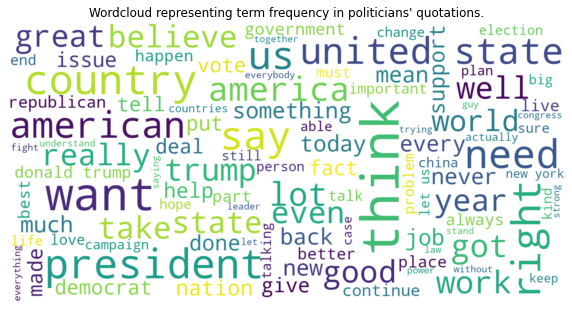

In [6]:
most_common = read_most_common("data/misc/most_common_words_1000.txt")
most_common = most_common[:100]
stemmer = PorterStemmer()
most_common_stemmed = [stemmer.stem(word).lower() for word in most_common]
stemmed_words = {x: stemmer.stem(x).lower() for x in (words.unique())}

# and filter out the words w
filtered_words = [word for word in words if stemmed_words[word] not in most_common_stemmed]
plt.rcParams["figure.figsize"] = (10,10)

wordcloud = WordCloud(width=1600, height = 800, max_font_size=150, max_words=100, background_color="white")
wordcloud.generate(" ".join(filtered_words))

quotes = quotes.apply(lambda quote: remove_words(quote, most_common, stem = True))
quotes = list(quotes)

plt.axis("off")
plt.title("Wordcloud representing term frequency in politicians' quotations.")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

To divide the quotes into topics, we first tried to train a classifier on the data obtained from the [Manifesto-Project dataset](https://manifestoproject.wzb.eu), which provides sentences of the two parties' manifestos over years 2012, 2016, and 2020, labeled manually by experts to one of fifteen different topics/categories. Unfortunately, the data was too different from ours and thus the resulting accuracy was not satisfying. We then proceeded with unsupervised clustering.

In [7]:
if not os.path.exists("data/BERTopic_model"):
    # Create Topic Model
    create_model_topic_clusterer(quotes)
topic_model = BERTopic.load("data/BERTopic_model")
topics = topic_model.fit_transform(quotes)

Batches:  12%|█▏        | 381/3125 [04:44<23:16,  1.96it/s]

In [ ]:
freq = topic_model.get_topic_info()
freq.head(10)

### 3. Topic Analysis

### 4. Lexical and Syntactival Analysis

### 5. Political Classifier